# molPX Di-Ala example
<pre> 
Guillermo Pérez-Hernández  guille.perez@fu-berlin.de 
</pre>
   
In this notebook we will be using a trajectory of Di-Ala-peptide to easily identify conformations in the Ramachandran plot.

In [2]:
from os.path import exists
import molpx
from matplotlib import pylab as plt
%matplotlib notebook
import pyemma
import numpy as np

## Start from files on disk

In [3]:
top = molpx._molpxdir(join='notebooks/data/ala2.pdb')
# What data do we  have?
if exists('/group/ag_cmb/scratch/gph82/Di-Ala-nbdata/ala2.dcd'):
    MD_trajfiles = ['/group/ag_cmb/scratch/gph82/Di-Ala-nbdata/ala2.dcd'] #long trajectory
elif exists('/home/guille/ala2.dcd'):
    MD_trajfiles = ['/home/guille/ala2.dcd'] # extra for Stralsund
else:
    MD_trajfiles = [molpx._molpxdir(join='notebooks/data/ala2.mini.xtc')] #short trajectory

## Featurize to Ramachandran $(\phi,\psi)$-pairs with `PyEMMA`

In [4]:
feat = pyemma.coordinates.featurizer(top)
feat.add_backbone_torsions()
src  = pyemma.coordinates.source(MD_trajfiles, features=feat)
Y = src.get_output()

## Visualize a FES and the molecular structures behind it
Execute the following cell and click either on the FES or on the slidebar

<IPython.core.display.Javascript object>


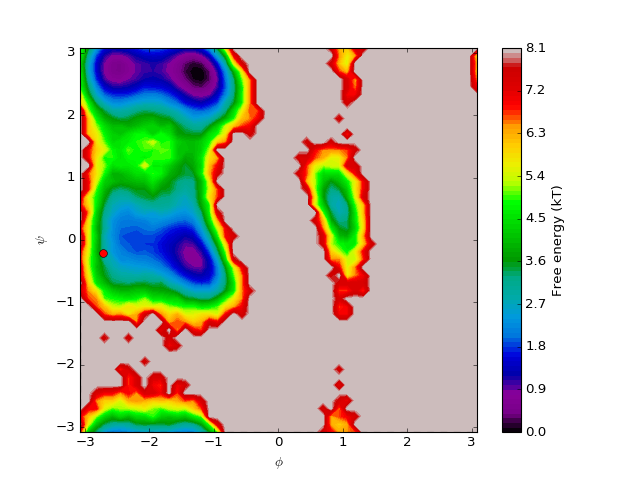

In [5]:
ax, fig, iwd, data_sample, geom = molpx.visualize.FES(MD_trajfiles, 
                                                      top,    
                                                      Y,                
                                                      #proj_idxs=[1],
                                                      nbins=50,
                                                      n_overlays=5,
                                                      proj_labels=['$\phi$', 
                                                                   '$\psi$'],
                                                      atom_selection="symbol != H",     
                       
                                          )
iwd.center_view()
iwd.display(gui=True)

## Visualize trajectories, FES and molecular structures

<IPython.core.display.Javascript object>


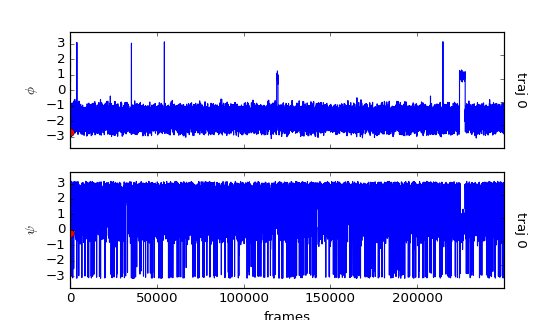

<IPython.core.display.Javascript object>


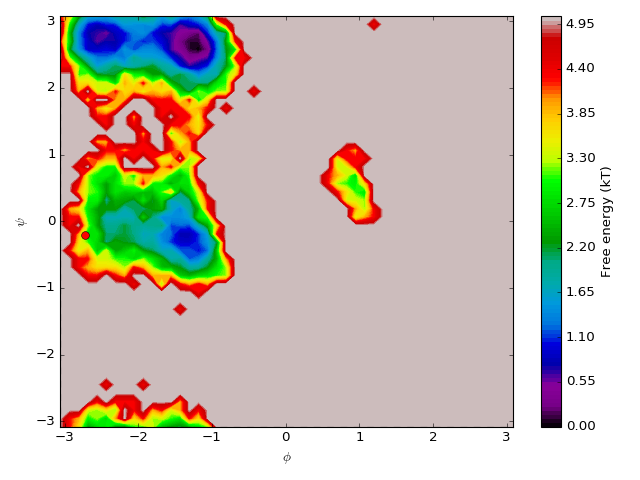

In [6]:
__, myfig, iwd, __ = molpx.visualize.traj(MD_trajfiles,     
                                          top,                                                                                                                              
                                          Y,                                        
                                          plot_FES = True,                                        
                                          #dt = dt*1e-6, tunits='ms',                                           
                                          max_frames=10000,
                                          proj_idxs=[0, 1],
                                          panel_height=2,    
                                          proj_labels=['$\phi$', '$\psi$']
                          )
myfig.tight_layout()
iwd.center_view()
iwd

# Intermediate steps: using molpx to generate a regspace sample of the data
See the documentation of `molpx.generate.sample` to find out about all possible options:
```
molpx.generate.sample(MD_trajectories, MD_top, projected_trajectories, proj_idxs=[0, 1], n_points=100, n_geom_samples=1, keep_all_samples=False, proj_stride=1, verbose=False, return_data=False)
```

In [7]:
data_sample, geoms = molpx.generate.sample(MD_trajfiles,                                            
                                           top, 
                                           Y,                                            
                                           n_points=200   ,
                                            n_geom_samples=5,
                                           keep_all_samples=True,
                                    )
data_sample.shape, geoms

02-07-17 20:25:12 pyemma.coordinates.clustering.regspace.RegularSpaceClustering[2] WARNING  Maximum number of cluster centers reached. Consider increasing max_centers or choose a larger minimum distance, dmin.
02-07-17 20:25:12 pyemma.coordinates.clustering.regspace.RegularSpaceClustering[2] INFO     Presumably finished estimation. Message: Used data for centers: 30.00%


/home/guille/miniconda3/lib/python3.5/site-packages/pyemma/coordinates/clustering/regspace.py:151: UserWarning: Maximum number of cluster centers reached. Consider increasing max_centers or choose a larger minimum distance, dmin.
  warnings.warn(msg)


((212, 2),
 [<mdtraj.Trajectory with 212 frames, 22 atoms, 3 residues, and unitcells at 0x7f786c499be0>,
  <mdtraj.Trajectory with 212 frames, 22 atoms, 3 residues, and unitcells at 0x7f786c496e80>,
  <mdtraj.Trajectory with 212 frames, 22 atoms, 3 residues, and unitcells at 0x7f786c4acac8>,
  <mdtraj.Trajectory with 212 frames, 22 atoms, 3 residues, and unitcells at 0x7f786c4b8518>,
  <mdtraj.Trajectory with 212 frames, 22 atoms, 3 residues, and unitcells at 0x7f786c4c2cc0>])

## Link the PDF plot with the sampled structures and visually explore the FES 
Click either on the plot or on the widget slidebar: they're connected! 

<IPython.core.display.Javascript object>


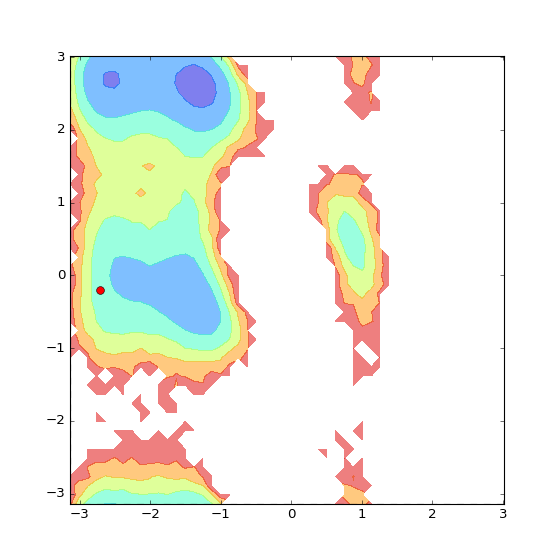

/home/guille/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


In [8]:
# Replot the FES
plt.figure(figsize=(7,7))
h, (x,y) = np.histogramdd(np.vstack(Y)[:,:2], bins=50)
plt.contourf(x[:-1], y[:-1], -np.log(h.T), alpha=.50)
# Create the linked widget
linked_wdg = molpx.visualize.sample(data_sample, 
                              geoms,                      
                              plt.gca(), 
                              clear_lines=True,
                              #sticky=True,                              
                              
                            )
linked_wdg.center_view()
linked_wdg

# Paths samples along the different projections (=axis)

In [9]:
paths_dict, idata = molpx.generate.projection_paths(MD_trajfiles, 
                                                    top, 
                                                    Y, 
                                                    n_points=50,
                                                    proj_idxs=[0,1],
                                                    n_projs=3,
                                                    proj_dim = 3, 
                                                    verbose=False, 
                                        )

In [10]:
# Choose the coordinate and the tyep of path
coord = 1
path_type = 'min_rmsd'
#path_type = 'min_disp'
igeom = paths_dict[coord][path_type]["geom"]
ipath = paths_dict[coord][path_type]["proj"]

# Choose the proj_idxs for the path and the FES 
# to be shown
proj_idxs = [0,1]

<IPython.core.display.Javascript object>


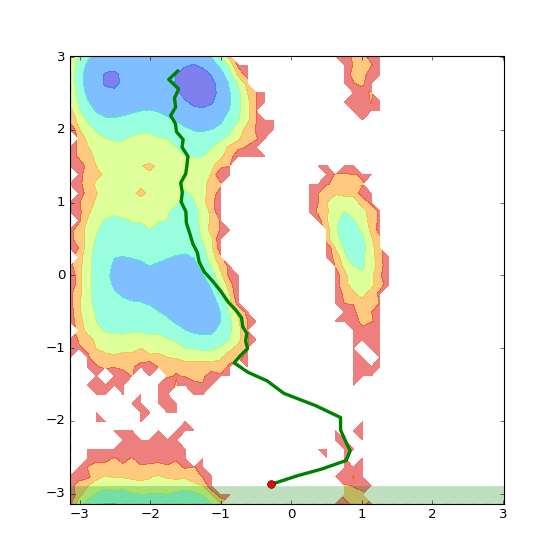

/home/guille/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


In [11]:
plt.figure(figsize=(7,7))
h, (x,y) = np.histogramdd(np.vstack(Y)[:,proj_idxs], bins=50)
plt.contourf(x[:-1], y[:-1], -np.log(h.T), alpha=.50)

linked_wdg = molpx.visualize.sample(ipath[:,proj_idxs], 
                                    igeom,                             
                                    plt.gca(), 
                                    clear_lines=True,
                                    n_smooth = 2, 
                                    plot_path=True,                                                            
                                    #radius=True,
                            )
iwd.center_view()
linked_wdg

# Let's do TICA and try to look a the correlations in a TICA analysis

In [12]:
feat = pyemma.coordinates.featurizer(top)
#feat.add_backbone_torsions(cossin=True)
feat.add_distances(feat.topology.select('symbol != H'))
src  = pyemma.coordinates.source(MD_trajfiles, features=feat)
tica = pyemma.coordinates.tica(src, lag=10)
Y_tica = tica.get_output()

02-07-17 20:26:20 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[6] WARNING  The 1D arrays input for add_distances() have been sorted, and index duplicates have been eliminated.
Check the output of describe() to see the actual order of the features


<IPython.core.display.Javascript object>


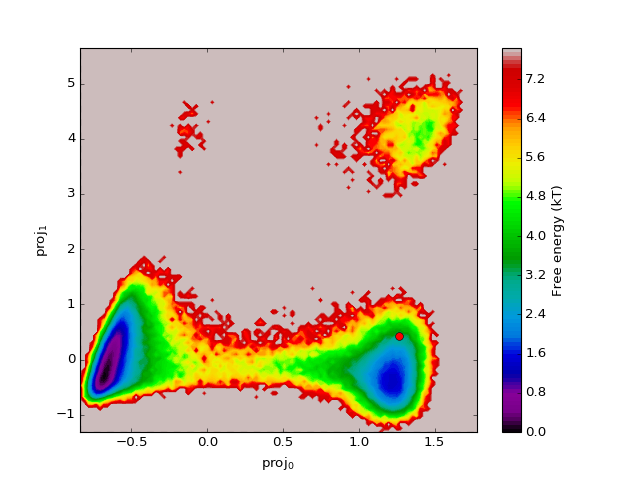

In [13]:
ax, fig, iwd, data_sample, geom = molpx.visualize.FES(MD_trajfiles, 
                                                      top,                                                       
                                                      Y_tica,                                                       
                                                      n_overlays=5,
                                                      sticky=True,
                                          )
iwd.center_view()
iwd.display(gui=True)

<IPython.core.display.Javascript object>


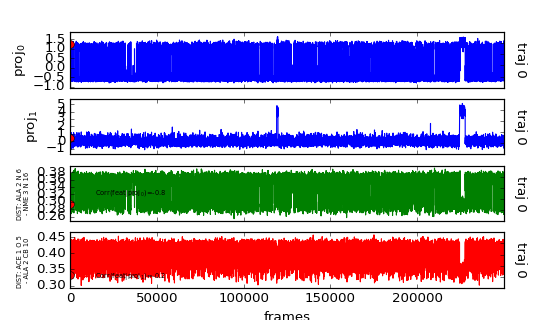

<IPython.core.display.Javascript object>


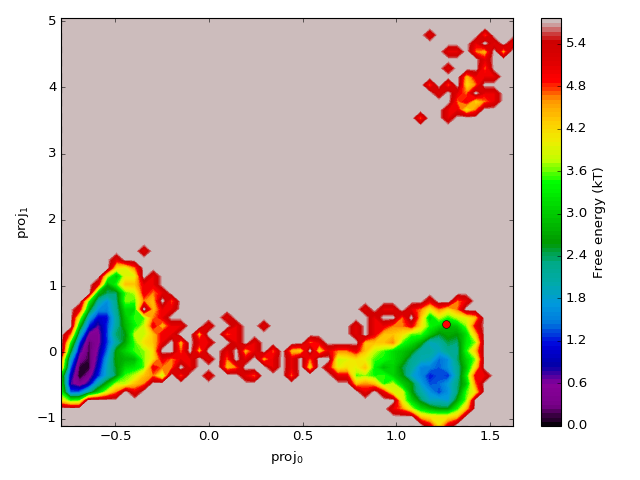

In [14]:
__, myfig, iwd, __ = molpx.visualize.traj(MD_trajfiles,     
                                          top,                                                                                                                              
                                          Y_tica,                                        
                                          plot_FES = True,                                        
                                          #dt = dt*1e-6, tunits='ms',                                           
                                          max_frames=10000,
                                          #proj_idxs=[0,1],
                                          panel_height=2,                                              
                                          projection=tica
                          )
myfig.tight_layout()
iwd.center_view()
iwd

In [15]:
paths_dict, idata = molpx.generate.projection_paths(MD_trajfiles, 
                                                    top, 
                                                    Y_tica, 
                                                    n_points=50,
                                                    proj_idxs=[0,1],
                                                    n_projs=2,
                                                    proj_dim = 2, 
                                                    verbose=False, 
                                        )

In [16]:
# Choose the coordinate and the type of path
coord = 0
path_type = 'min_rmsd'
#path_type = 'min_disp'
igeom = paths_dict[coord][path_type]["geom"]
ipath = paths_dict[coord][path_type]["proj"]

# Choose the proj_idxs for the path and the FES 
# to be shown
proj_idxs = [0,1]

<IPython.core.display.Javascript object>


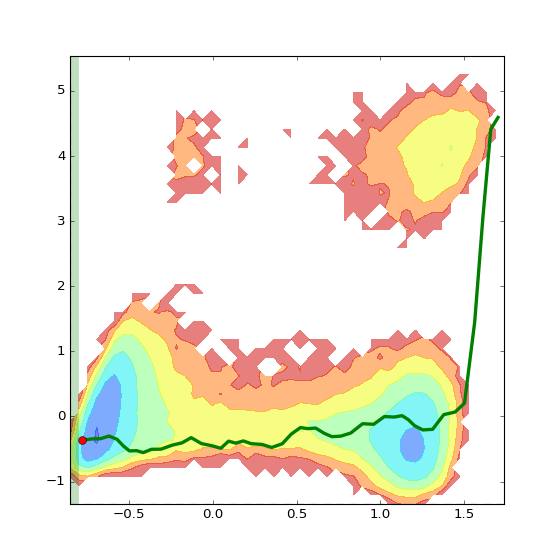

/home/guille/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


In [17]:
plt.figure(figsize=(7,7))
h, (x,y) = np.histogramdd(np.vstack(Y_tica)[:,proj_idxs], bins=50)
plt.contourf(x[:-1], y[:-1], -np.log(h.T), alpha=.50)

linked_wdg = molpx.visualize.sample(ipath[:,proj_idxs], 
                                    igeom,
                                    plt.gca(), 
                                    clear_lines=True,
                                    n_smooth = 1, 
                                    plot_path=True,   
                                   )
# You can even choose to add the correlations a posteriori                                         
molpx.visualize.correlations(tica, widget=linked_wdg, proj_idxs=0)
linked_wdg.center_view()
linked_wdg